In [14]:
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from dataclasses import dataclass
import concurrent.futures
from collections import defaultdict
import typing
from torch import optim
import torch
import os
import random
import copy


%load_ext autoreload
%autoreload 2
import env
import network
import player


BOARD_XSIZE = env.BOARD_XSIZE
BOARD_YSIZE = env.BOARD_YSIZE

DIMS=(BOARD_XSIZE,BOARD_YSIZE)


EPISODES_PER_AGENT = 64
TRAIN_EPOCHS = 500000
MODEL_SAVE_INTERVAL = 100
MAKE_OPPONENT_INTERVAL = 2000
SUMMARY_STATS_INTERVAL = 10
RANDOM_SEED = 42

SUMMARY_DIR = './summary'
MODEL_DIR = './models'

# create result directory
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)

use_cuda = torch.cuda.is_available()
torch.manual_seed(RANDOM_SEED)

cuda = torch.device("cuda")
cpu = torch.device("cpu")

if use_cuda:
    device = cuda
else:
    device = cpu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of network failed: Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/codespace/.python/current/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/workspaces/omegasus/amogus-rl/network.py", line 117
    sample_batch[] = trajectory_advantages
                 ^
SyntaxErr

In [15]:
impostor_actor = network.Actor().to(device)
impostor_critic = network.Critic().to(device)
impostor_actor_optimizer = optim.Adam(impostor_actor.parameters(), lr=network.ACTOR_LR)
impostor_critic_optimizer = optim.Adam(impostor_critic.parameters(), lr=network.CRITIC_LR)

crewmate_actor = network.Actor().to(device)
crewmate_critic = network.Critic().to(device)
crewmate_actor_optimizer = optim.Adam(crewmate_actor.parameters(), lr=network.ACTOR_LR)
crewmate_critic_optimizer = optim.Adam(crewmate_critic.parameters(), lr=network.CRITIC_LR)

# Get Writer
writer = SummaryWriter(log_dir=SUMMARY_DIR)

impostor_step = 0
crewmate_step = 0

In [16]:
def random_valid_location() -> tuple[int, int]:
    x = np.random.randint(0, BOARD_XSIZE)
    y = np.random.randint(0, BOARD_YSIZE)
    return (x, y)


@dataclass
class GameSummary:
    configuration: tuple[str, str, str]
    actor_is_impostor: bool


def play(
    actor_engine: player.ActorPlayer,
    actor_is_impostor: bool,
    other_engines: list[player.Player],
) -> tuple[
    list[env.Observation],
    list[env.Action],
    list[float],
    list[float],
    list[float],
    GameSummary,
]:
    # create environment
    initial_state = env.State(
        {},
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
    )

    # randomize task location
    for _ in range(10):
        location = random_valid_location()
        initial_state.tasks[location] += 3

    # create actor player at random location
    actor_state = env.PlayerState(random_valid_location(), actor_is_impostor)
    # create other players at random locations
    other_state = [
        env.PlayerState(random_valid_location(), False) for _ in other_engines
    ]

    # set the players in the environment
    initial_state.players = {str(i): s for i, s in enumerate(other_state)}
    initial_state.players["actor"] = actor_state

    # set the player data
    agent_engines = {str(i): e for i, e in enumerate(other_engines)}
    agent_engines["actor"] = actor_engine

    impostor = (
        str(np.random.randint(0, len(other_engines))) if actor_is_impostor else "actor"
    )

    e = env.AmogusEnv(initial_state)

    s_t: list[env.Observation] = []
    a_t: list[env.Action] = []
    r_t: list[float] = []
    # play the game
    last_obs = e.reset()

    done = False
    while not done:
        # gather actions
        actions = {}
        for agent, agent_engine in agent_engines.items():
            chosen_action = agent_engine.play(agent == impostor, last_obs[agent])
            actions[agent] = chosen_action
            # if the player is the actor we're gathering data for, then we need to store the data
            if agent == "actor":
                s_t += [last_obs[agent]]
                a_t += [chosen_action]
        
        # step
        last_obs, rewards, terminateds, truncateds, _ = e.step(actions)

        # add rewards
        r_t += [rewards["actor"]]

        for agent in last_obs.keys():
            if terminateds[agent] or truncateds[agent]:
                del agent_engines[agent]
                # if the actor we're gathering data for is dead, then we need to stop
                if agent == "actor":
                    done = True

    # compute advantage and value
    critic_network = impostor_critic if actor_is_impostor else crewmate_critic
    d_t = network.compute_advantage(critic_network, s_t, r_t)
    v_t = network.compute_value(r_t)

    summary = GameSummary(
        tuple(sorted(e.name() for e in other_engines)), actor_is_impostor
    )

    return s_t, a_t, r_t, d_t, v_t, summary


In [17]:
opponent_pool: list[player.Player] = [
    player.RandomPlayer(),
    player.GreedyPlayer(),
]

# a temp buffer of the current model's rewards
crewmate_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])
impostor_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])


# the history of rewards over time
crewmate_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])
impostor_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])

In [18]:
for _ in range(TRAIN_EPOCHS):
    crewmate_s_batch:list[env.Observation] = []
    crewmate_a_batch:list[env.Action] = []
    crewmate_r_batch:list[float] = []
    crewmate_d_batch:list[float] = []
    crewmate_v_batch:list[float] = []
    
    impostor_s_batch:list[env.Observation] = []
    impostor_a_batch:list[env.Action] = []
    impostor_r_batch:list[float] = []
    impostor_d_batch:list[float] = []
    impostor_v_batch:list[float] = []

    # create actor player
    nn_player = player.ActorPlayer(
        impostor_actor, impostor_critic, impostor_step,
        crewmate_actor, crewmate_critic, crewmate_step,
    )

    futures = []
    for i in range(EPISODES_PER_AGENT):
        others = [random.choice(opponent_pool)]*3
        # play the game
        future = play(nn_player, False, others)
        futures.append(future)

    for i in range(EPISODES_PER_AGENT):
        others = [random.choice(opponent_pool)]*3
        # play the game
        future = play(nn_player, True, others)
        futures.append(future)

    
    for future in futures:
        s_t, a_t, r_t, d_t, v_t, game_summary = future

        configuration = game_summary.configuration
        r = np.sum(r_t)

        if game_summary.actor_is_impostor:
            impostor_s_batch += s_t
            impostor_a_batch += a_t
            impostor_r_batch += r_t
            impostor_d_batch += d_t
            impostor_v_batch += v_t
            # statistics
            impostor_rewards_vs[configuration] += [r]
        else:
            crewmate_s_batch += s_t
            crewmate_a_batch += a_t
            crewmate_r_batch += r_t
            crewmate_d_batch += d_t
            crewmate_v_batch += v_t
            # statistics
            crewmate_rewards_vs[configuration] += [r]


    crewmate_actor_losses, crewmate_critic_losses = network.train_ppo(
        crewmate_actor,
        crewmate_critic,
        crewmate_actor_optimizer,
        crewmate_critic_optimizer,
        crewmate_s_batch,
        crewmate_a_batch,
        crewmate_d_batch,
        crewmate_v_batch
    )

    impostor_actor_losses, impostor_critic_losses = network.train_ppo(
        impostor_actor,
        impostor_critic,
        impostor_actor_optimizer,
        impostor_critic_optimizer,
        impostor_s_batch,
        impostor_a_batch,
        impostor_d_batch,
        impostor_v_batch
    )

    for crewmate_actor_loss, crewmate_critic_loss, impostor_actor_loss, impostor_critic_loss in zip(crewmate_actor_losses, crewmate_critic_losses, impostor_actor_losses, impostor_critic_losses):
        writer.add_scalar('impostor_actor_loss', impostor_actor_loss, impostor_step)
        writer.add_scalar('impostor_critic_loss', impostor_critic_loss, impostor_step)

        writer.add_scalar('crewmate_actor_loss', crewmate_actor_loss, crewmate_step)
        writer.add_scalar('crewmate_critic_loss', crewmate_critic_loss, crewmate_step)

        if impostor_step % SUMMARY_STATS_INTERVAL == 0:
            for opponent_name, rewards in impostor_rewards_vs.items():
                if len(rewards) > 50:
                    avg_reward = np.array(rewards).mean()
                    writer.add_scalar(f'impostor_reward_against_{opponent_name}', avg_reward, impostor_step)
                    impostor_rewards_vs[opponent_name] = []
                    impostor_rewards_history[opponent_name] += [(impostor_step, avg_reward)]

        if crewmate_step % SUMMARY_STATS_INTERVAL == 0:
            for opponent_name, rewards in crewmate_rewards_vs.items():
                if len(rewards) > 50:
                    avg_reward = np.array(rewards).mean()
                    writer.add_scalar(f'crewmate_reward_against_{opponent_name}', avg_reward, crewmate_step)
                    crewmate_rewards_vs[opponent_name] = []
                    crewmate_rewards_history[opponent_name] += [(crewmate_step, avg_reward)]

        def clone_nn(nn):
            new_nn = copy.deepcopy(nn)
            new_nn.eval()
            new_nn.to(device)
            return new_nn

        if impostor_step % MAKE_OPPONENT_INTERVAL == 0:
            # create a new opponent
            frozen_impostor_actor = clone_nn(impostor_actor)
            frozen_impostor_critic = clone_nn(impostor_critic)
            frozen_crewmate_actor = clone_nn(crewmate_actor)
            frozen_crewmate_critic = clone_nn(crewmate_critic)
            frozen_nn_player = player.ActorPlayer(
                frozen_impostor_actor, frozen_impostor_critic, impostor_step,
                frozen_crewmate_actor, frozen_crewmate_critic, crewmate_step,
            )
            opponent_pool.append(frozen_nn_player)

        # Save the neural net parameters to disk.
        if impostor_step % MODEL_SAVE_INTERVAL == 0:
            torch.save(impostor_actor.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_actor.ckpt")
            torch.save(impostor_critic.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_critic.ckpt")

        # Save the neural net parameters to disk.
        if crewmate_step % MODEL_SAVE_INTERVAL == 0:
            torch.save(crewmate_actor.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_actor.ckpt")
            torch.save(crewmate_critic.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_critic.ckpt")
        
        crewmate_step += 1
        impostor_step += 1

KeyboardInterrupt: 

Interrupted kernel due to convergence.

In [19]:
others = []
for _ in range(3):
    others.append(player.RandomPlayer())
# play the game            
s_t, a_t, r_t, d_t, v_t, _ = play(nn_player, False, others)

In [20]:
for s, a, r, d, v in zip(s_t, a_t, r_t, d_t, v_t):
    print("-----------------------------------")
    env.print_obs(s)
    env.print_action(a)
    print("reward:", r)
    print("advantage:", d)
    print("value:", v)

-----------------------------------
🧱🧱📦🧑‍🚀📦
🧱🧱⬛⬛⬛
🧱🧱🧑‍🚀⬛📦
🧱🧱📦📦⬛
🧱🧱🧱🧱🧱
Move Left
reward: 0.0
advantage: 0.20672677622121194
value: 0.21397163371499994
-----------------------------------
🧱🧱🧑‍🚀⬛📦
🧱🧱⬛⬛⬛
🧱🧱🧑‍🚀⬛📦
🧱🧱📦📦⬛
🧱🧱🧱🧱🧱
Move Left
reward: 0.0
advantage: 0.2981615706738137
value: 0.30567376244999994
-----------------------------------
🧱🧱📦🧑‍🚀📦
🧱🧱⬛⬛⬛
🧱🧱🧑‍🚀⬛📦
🧱🧱📦📦⬛
🧱🧱🧱🧱🧱
Move Up
reward: 0.0
advantage: 0.42943194600621193
value: 0.43667680349999993
-----------------------------------
🧱🧱⬛⬛📦
🧱🧱📦🧑‍🚀📦
🧱🧱🧑‍🚀⬛⬛
🧱🧱⬛⬛📦
🧱🧱📦📦⬛
Move Down
reward: 0.0
advantage: 0.6165757970732497
value: 0.6238240049999999
-----------------------------------
🧱🧱📦⬛📦
🧱🧱⬛⬛⬛
🧱🧱🧑‍🚀⬛📦
🧱🧱📦📦⬛
🧱🧱🧱🧱🧱
Move Down
reward: 0.5
advantage: 0.8833887889498113
value: 0.8911771499999999
-----------------------------------
🧱🧱⬛⬛⬛
🧱🧱⬛⬛📦
🧱🧱🧑‍🚀📦🧑‍🚀
🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱
Move Right
reward: 0.5
advantage: 0.5510174468400776
value: 0.5588245
-----------------------------------
🧱⬛⬛⬛⬛
🧱⬛⬛📦⬛
🧱📦🧑‍🚀⬛⬛
🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱
Move Right
reward: 0.0
advantage: 0.075242753308117

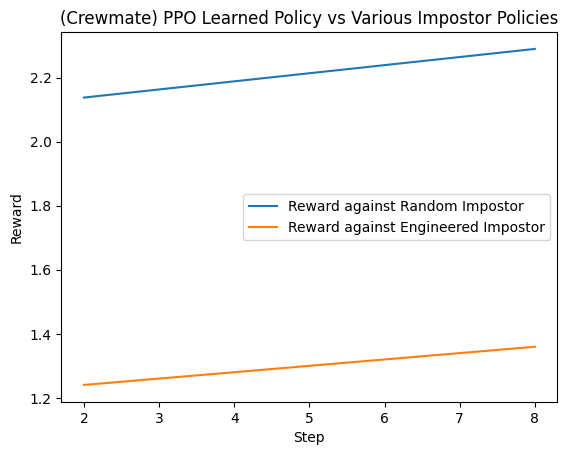

In [21]:
import matplotlib.pyplot as plt

# plot the crewmate rewards against random opponents
rx, ry= zip(*crewmate_rewards_history[('random', 'random', 'random')])
gx, gy= zip(*crewmate_rewards_history[('greedy', 'greedy', 'greedy')])
rx = [x / 10 for x in rx]
gx = [x / 10 for x in gx]


plt.plot(rx, ry, label='Reward against Random Impostor')
plt.plot(gx, gy, label='Reward against Engineered Impostor')

plt.title('(Crewmate) PPO Learned Policy vs Various Impostor Policies')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

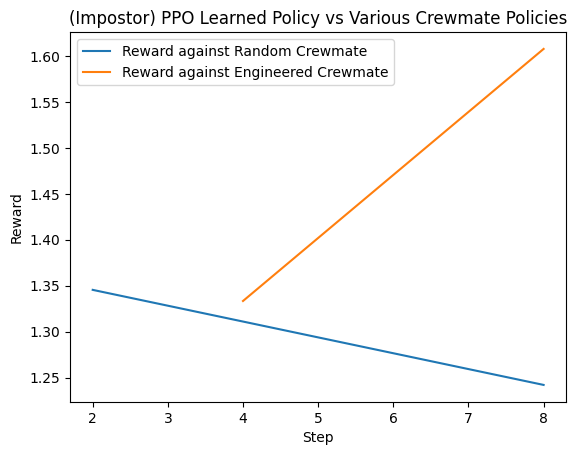

In [22]:
import matplotlib.pyplot as plt

# plot the impostor against random opponents
rx, ry= zip(*impostor_rewards_history[('random', 'random', 'random')])
gx, gy= zip(*impostor_rewards_history[('greedy', 'greedy', 'greedy')])
rx = [x / 10 for x in rx]
gx = [x / 10 for x in gx]

plt.plot(rx, ry, label='Reward against Random Crewmate')
plt.plot(gx, gy, label='Reward against Engineered Crewmate')
plt.title('(Impostor) PPO Learned Policy vs Various Crewmate Policies')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [26]:
import ray
ray.init()

@ray.remote
def play_benchmark(engine: player.Player, is_impostor: bool, other_engines: list[player.Player]) -> list[env.Reward]:
    # create environment
    initial_state = env.State(
        [],
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
    )

    # randomize task location
    for _ in range(5):
        location = random_valid_location()
        initial_state.tasks[location] += 5

    # create actor player at random location
    actor_playerstate = env.PlayerState(random_valid_location(), is_impostor, False)
    # create other players at random locations
    other_playerstate = [env.PlayerState(random_valid_location(), False, False) for _ in other_engines]
    # If the actor is not an impostor, then the impostor is randomly chosen from the others.
    if not is_impostor:
        random.choice(other_playerstate).impostor = True

    # set the players in the environment
    initial_state.players = [actor_playerstate] + other_playerstate
    # set the player engines
    player_engines = [engine] + other_engines

    # shuffle the player indices such that the corresponding player states and engines have the same indices
    random_indices = np.random.permutation(len(player_engines))
    initial_state.players = [initial_state.players[i] for i in random_indices]
    player_engines = [player_engines[i] for i in random_indices]

    actor_index = env.Player(np.argwhere(random_indices==0)[0][0])

    e = env.Env(initial_state)

    r_t: list[env.Reward] = []
    # play the game
    while not e.game_over():
        for player, player_engine in enumerate(player_engines):
            player = env.Player(player)
            if player == actor_index:
                _, _, chosen_action = player_engine.play(player, e)
                e.play(chosen_action, player)
            else:
                if e.game_over_for(player):
                    continue
                _, _, chosen_action = player_engine.play(player, e)
                e.play(chosen_action, player)
        # step and get rewards
        rewards = e.step()
        r_t += [rewards[actor_index]]
        # if the actor we're gathering data for is dead, then we need to stop
        if e.game_over_for(env.Player(actor_index)):
            break

    return r_t

# Run multiple benchmarks in parallel using Ray
results = ray.get([play_benchmark.remote(engine, is_impostor, other_engines) for engine in engines])


2023-05-26 16:20:37,384	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.69gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-05-26 16:20:38,922	INFO worker.py:1625 -- Started a local Ray instance.


AttributeError: module 'env' has no attribute 'Reward'

In [24]:
SAMPLES = 50

nn_crewmate_vs_random_impostor = []
random_crewmate_vs_random_impostor = []
greedy_crewmate_vs_random_impostor = []

# run a couple simulations to find how well the learned policy does against a random impostor
for _ in range(SAMPLES):
    r_t = play_benchmark(nn_player, False, [player.RandomPlayer()]*3)
    nn_crewmate_vs_random_impostor.append(np.sum(r_t))

# run a couple simulations to find how well the random policy does against a random impostor
for _ in range(SAMPLES):
    r_t = play_benchmark(player.RandomPlayer(), False, [player.RandomPlayer()]*3)
    random_crewmate_vs_random_impostor.append(np.sum(r_t))

# run a couple simulations to find how well the greedy policy does against a random impostor
for _ in range(SAMPLES):
    r_t = play_benchmark(player.GreedyPlayer(), False, [player.RandomPlayer()]*3)
    greedy_crewmate_vs_random_impostor.append(np.sum(r_t))


nn_impostor_vs_random_crewmate = []
random_impostor_vs_random_crewmate = []
greedy_impostor_vs_random_crewmate = []

# run a couple simulations to find how well the learned policy does against a random crewmate
for _ in range(SAMPLES):
    r_t = play_benchmark(nn_player, True, [player.RandomPlayer()]*3)
    nn_impostor_vs_random_crewmate.append(np.sum(r_t))

# run a couple simulations to find how well the random policy does against a random crewmate
for _ in range(SAMPLES):
    r_t = play_benchmark(player.RandomPlayer(), True, [player.RandomPlayer()]*3)
    random_impostor_vs_random_crewmate.append(np.sum(r_t))

# run a couple simulations to find how well the greedy policy does against a random crewmate
for _ in range(SAMPLES):
    r_t = play_benchmark(player.GreedyPlayer(), True, [player.RandomPlayer()]*3)
    greedy_impostor_vs_random_crewmate.append(np.sum(r_t))

NameError: name 'play_benchmark' is not defined

In [25]:
print("nn_crewmate_vs_random_impostor", np.mean(nn_crewmate_vs_random_impostor))
print("random_crewmate_vs_random_impostor", np.mean(random_crewmate_vs_random_impostor))
print("engineered_crewmate_vs_random_impostor", np.mean(greedy_crewmate_vs_random_impostor))
print()
print("nn_impostor_vs_random_crewmate", np.mean(nn_impostor_vs_random_crewmate))
print("random_impostor_vs_random_crewmate", np.mean(random_impostor_vs_random_crewmate))
print("engineered_impostor_vs_random_crewmate", np.mean(greedy_impostor_vs_random_crewmate))

nn_crewmate_vs_random_impostor nan
random_crewmate_vs_random_impostor nan
engineered_crewmate_vs_random_impostor nan



/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'nn_impostor_vs_random_crewmate' is not defined

In [ ]:
print("nn_policy_vs_random_policy (crewmate):" , np.mean(nn_crewmate_vs_random_impostor)/np.mean(random_crewmate_vs_random_impostor))
print("nn_policy_vs_engineered_policy (crewmate):" , np.mean(nn_crewmate_vs_random_impostor)/np.mean(greedy_crewmate_vs_random_impostor))
print()
print("nn_policy_vs_random_policy (impostor):" , np.mean(nn_impostor_vs_random_crewmate)/np.mean(random_impostor_vs_random_crewmate))
print("nn_policy_vs_engineered_policy (impostor):" , np.mean(nn_impostor_vs_random_crewmate)/np.mean(greedy_impostor_vs_random_crewmate))